<a href="https://colab.research.google.com/github/msasen/pytorch/blob/main/5_mesafe_hesaplama.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Veri indirme

In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 63 bytes


In [16]:
! mkdir kaggle
! chmod 600 /kaggle.json
! cp kaggle.json /content/.kaggle
! chmod 600 /content/kaggle/kaggle.json
! ls

mkdir: cannot create directory ‘kaggle’: File exists
chmod: cannot access '/kaggle.json': No such file or directory
dataset  kaggle  kaggle.json  sample_data


In [15]:
! kaggle datasets list

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.8/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.8/dist-packages/kaggle/api/kaggle_api_extended.py", line 164, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [5]:
!kaggle competitions download -c new-york-city-taxi-fare-prediction

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.8/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.8/dist-packages/kaggle/api/kaggle_api_extended.py", line 164, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [6]:
! mkdir dataset
! ls

dataset  kaggle.json  sample_data


In [7]:
! unzip /content/new-york-city-taxi-fare-prediction.zip -d /content/dataset

unzip:  cannot find or open /content/new-york-city-taxi-fare-prediction.zip, /content/new-york-city-taxi-fare-prediction.zip.zip or /content/new-york-city-taxi-fare-prediction.zip.ZIP.


In [ ]:
import pandas
import random
filename = r"/content/dataset/train.csv"
n = sum(1 for line in open(filename)) - 1 #number of records in file (excludes header)
s = 100000 #desired sample size
skip = sorted(random.sample(range(1,n+1),n-s)) #the 0-indexed header will not be included in the skip list
df = pandas.read_csv(filename, skiprows=skip)
df.to_csv("temp.csv")

# Model eğitimi

In [18]:

#PyTorch 

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as torch_optim
from torchvision import models
from torch.nn import init
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils import data
from torch.optim import lr_scheduler

#sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing


#other
from IPython.core.debugger import set_trace
import pandas as pd
import numpy as np
from collections import Counter
from datetime import datetime
import math 
from google.colab import files
import io
import datetime as dt
import re
import pandas_profiling
import pandas_profiling as pp
from math import sqrt

#graphs
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
import pylab as plt
import matplotlib.dates as dates
import seaborn as sns
import pylab
import matplotlib
import matplotlib.dates
from IPython.display import display
import plotly.graph_objects as go


%matplotlib inline

In [78]:
uploaded = files.upload()
df_train = pd.read_csv(io.BytesIO(uploaded['temp.csv']))


Saving temp.csv to temp (2).csv


In [79]:
df_train = pd.read_csv(io.BytesIO(uploaded['temp.csv']))
df_train

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,0,2014-03-03 19:03:42.0000005,12.5,2014-03-03 19:03:42 UTC,-73.998881,40.734511,-73.971341,40.760929,1
1,1,2012-10-13 02:31:22.0000001,31.5,2012-10-13 02:31:22 UTC,-74.007458,40.726242,-73.870459,40.762649,1
2,2,2012-07-09 09:26:00.000000168,11.7,2012-07-09 09:26:00 UTC,-73.999803,40.734717,-73.978992,40.750105,1
3,3,2012-11-12 12:09:00.00000091,7.0,2012-11-12 12:09:00 UTC,-73.963158,40.776832,-73.973088,40.763702,1
4,4,2010-12-31 21:32:53.0000001,5.3,2010-12-31 21:32:53 UTC,-73.928211,40.865160,-73.935785,40.850214,1
...,...,...,...,...,...,...,...,...,...
99995,99995,2014-12-09 08:49:58.0000001,5.5,2014-12-09 08:49:58 UTC,-73.969435,40.757047,-73.975607,40.751356,1
99996,99996,2012-09-06 00:14:10.0000001,9.0,2012-09-06 00:14:10 UTC,-73.994135,40.720177,-73.963127,40.711737,1
99997,99997,2011-06-20 14:13:18.0000003,4.9,2011-06-20 14:13:18 UTC,-73.990926,40.745783,-73.988379,40.754664,1
99998,99998,2011-12-03 23:24:15.0000003,12.1,2011-12-03 23:24:15 UTC,-73.987257,40.737795,-73.961614,40.795809,1


In [80]:
uploaded = files.upload()
df_test = pd.read_csv(io.BytesIO(uploaded['test.csv']))
df_test.head()

KeyError: ignored

In [98]:
test_df = pd.read_csv("/content/test.csv")
test_df.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24 UTC,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24 UTC,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44 UTC,-73.982524,40.751260,-73.979654,40.746139,1
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12 UTC,-73.981160,40.767807,-73.990448,40.751635,1
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12 UTC,-73.966046,40.789775,-73.988565,40.744427,1


In [60]:
from tqdm.notebook import tqdm, tnrange


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device
     


device(type='cuda', index=0)

In [24]:
df_train = df_train.loc[df_train.fare_amount > 0]
df_train.fare_amount.min()
df_test.shape, df_train.shape

((9914, 7), (99996, 9))

In [25]:
train_X = df_train.drop(columns=['fare_amount'])
train_X.shape

(99996, 8)

In [26]:
Y = np.log(df_train.fare_amount)
print(Y)

0        2.525729
1        3.449988
2        2.459589
3        1.945910
4        1.667707
           ...   
99995    1.704748
99996    2.197225
99997    1.589235
99998    2.493205
99999    2.388763
Name: fare_amount, Length: 99996, dtype: float64


In [27]:
test_X = df_test
df = train_X.append(test_X,sort=False)

In [28]:
def haversine_distance(df, lat1, long1, lat2, long2):
    """
    Calculates the haversine distance between 2 sets of GPS coordinates in df
    """
    r = 6371  # average radius of Earth in kilometers
       
    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])
    
    delta_phi = np.radians(df[lat2]-df[lat1])
    delta_lambda = np.radians(df[long2]-df[long1])
     
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = (r * c) # in kilometers

    return d

In [29]:
df['dist_km'] = haversine_distance(df,'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude')
df.head()

,Unnamed: 0,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km
0,0.0,2014-03-03 19:03:42.0000005,2014-03-03 19:03:42 UTC,-73.998881,40.734511,-73.971341,40.760929,1,3.743191
1,1.0,2012-10-13 02:31:22.0000001,2012-10-13 02:31:22 UTC,-74.007458,40.726242,-73.870459,40.762649,1,12.230798
2,2.0,2012-07-09 09:26:00.000000168,2012-07-09 09:26:00 UTC,-73.999803,40.734717,-73.978992,40.750105,1,2.449834
3,3.0,2012-11-12 12:09:00.00000091,2012-11-12 12:09:00 UTC,-73.963158,40.776832,-73.973088,40.763702,1,1.682509
4,4.0,2010-12-31 21:32:53.0000001,2010-12-31 21:32:53 UTC,-73.928211,40.865160,-73.935785,40.850214,1,1.779809


In [30]:
df['EDTdate'] = pd.to_datetime(df['pickup_datetime'].str[:19]) - pd.Timedelta(hours=4)
df['Hour'] = df['EDTdate'].dt.hour
df['AMorPM'] = np.where(df['Hour']<12,'am','pm')
df['Weekday'] = df['EDTdate'].dt.strftime("%a")
df.head()

,Unnamed: 0,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km,EDTdate,Hour,AMorPM,Weekday
0,0.0,2014-03-03 19:03:42.0000005,2014-03-03 19:03:42 UTC,-73.998881,40.734511,-73.971341,40.760929,1,3.743191,2014-03-03 15:03:42,15,pm,Mon
1,1.0,2012-10-13 02:31:22.0000001,2012-10-13 02:31:22 UTC,-74.007458,40.726242,-73.870459,40.762649,1,12.230798,2012-10-12 22:31:22,22,pm,Fri
2,2.0,2012-07-09 09:26:00.000000168,2012-07-09 09:26:00 UTC,-73.999803,40.734717,-73.978992,40.750105,1,2.449834,2012-07-09 05:26:00,5,am,Mon
3,3.0,2012-11-12 12:09:00.00000091,2012-11-12 12:09:00 UTC,-73.963158,40.776832,-73.973088,40.763702,1,1.682509,2012-11-12 08:09:00,8,am,Mon
4,4.0,2010-12-31 21:32:53.0000001,2010-12-31 21:32:53 UTC,-73.928211,40.865160,-73.935785,40.850214,1,1.779809,2010-12-31 17:32:53,17,pm,Fri


In [31]:
cat_cols = ['Hour', 'AMorPM', 'Weekday']
cont_cols = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'passenger_count', 'dist_km']

  
# keep only the cols for the model


In [32]:
#make the cat categories as "category" and label encoder it.
for col in df.columns:
  if col in cat_cols:
    df[col] = LabelEncoder().fit_transform(df[col])
    df[col]= df[col].astype('category')


     

In [33]:
df.head()


,Unnamed: 0,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km,EDTdate,Hour,AMorPM,Weekday
0,0.0,2014-03-03 19:03:42.0000005,2014-03-03 19:03:42 UTC,-73.998881,40.734511,-73.971341,40.760929,1,3.743191,2014-03-03 15:03:42,15,1,1
1,1.0,2012-10-13 02:31:22.0000001,2012-10-13 02:31:22 UTC,-74.007458,40.726242,-73.870459,40.762649,1,12.230798,2012-10-12 22:31:22,22,1,0
2,2.0,2012-07-09 09:26:00.000000168,2012-07-09 09:26:00 UTC,-73.999803,40.734717,-73.978992,40.750105,1,2.449834,2012-07-09 05:26:00,5,0,1
3,3.0,2012-11-12 12:09:00.00000091,2012-11-12 12:09:00 UTC,-73.963158,40.776832,-73.973088,40.763702,1,1.682509,2012-11-12 08:09:00,8,0,1
4,4.0,2010-12-31 21:32:53.0000001,2010-12-31 21:32:53 UTC,-73.928211,40.865160,-73.935785,40.850214,1,1.779809,2010-12-31 17:32:53,17,1,0


In [34]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 109910 entries, 0 to 9913
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   Unnamed: 0         99996 non-null   float64       
 1   key                109910 non-null  object        
 2   pickup_datetime    109910 non-null  object        
 3   pickup_longitude   109910 non-null  float64       
 4   pickup_latitude    109910 non-null  float64       
 5   dropoff_longitude  109908 non-null  float64       
 6   dropoff_latitude   109908 non-null  float64       
 7   passenger_count    109910 non-null  int64         
 8   dist_km            109908 non-null  float64       
 9   EDTdate            109910 non-null  datetime64[ns]
 10  Hour               109910 non-null  category      
 11  AMorPM             109910 non-null  category      
 12  Weekday            109910 non-null  category      
dtypes: category(3), datetime64[ns](1), float64(6),

In [35]:
df = df[['Hour', 'AMorPM', 'Weekday','pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'passenger_count', 'dist_km']]
df

,Hour,AMorPM,Weekday,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,passenger_count,dist_km
0,15,1,1,40.734511,-73.998881,40.760929,-73.971341,1,3.743191
1,22,1,0,40.726242,-74.007458,40.762649,-73.870459,1,12.230798
2,5,0,1,40.734717,-73.999803,40.750105,-73.978992,1,2.449834
3,8,0,1,40.776832,-73.963158,40.763702,-73.973088,1,1.682509
4,17,1,0,40.865160,-73.928211,40.850214,-73.935785,1,1.779809
...,...,...,...,...,...,...,...,...,...
9909,8,0,3,40.796997,-73.968124,40.780388,-73.955643,6,2.124874
9910,13,1,1,40.803600,-73.945511,40.776371,-73.960213,6,3.270969
9911,16,1,3,40.726608,-73.991600,40.647011,-73.789742,6,19.183941
9912,21,1,0,40.735432,-73.985573,40.801731,-73.939178,6,8.343486


In [36]:
df_train = df[:99990]
df_test = df[99990:]

In [37]:
df_train.shape, df_test.shape

((99990, 9), (9920, 9))

In [38]:
#Normalizing 

from pandas.api.types import is_numeric_dtype

#"Compute the means and stds of `self.cont_names` columns to normalize them."
def Normalize(df):
  means,stds = {},{}
  cont_names = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'passenger_count', 'dist_km']
  for n in cont_names:
    assert is_numeric_dtype(df[n]), (f"""Cannot normalize '{n}' column as it isn't numerical. Are you sure it doesn't belong in the categorical set of columns?""")
    means[n],stds[n] = df[n].mean(),df[n].std()
    df[n] = (df[n]-means[n]) / (1e-7 + stds[n])


Normalize(df_train)
Normalize(df_test)
X = df_train

<ipython-input-38-6304aff3d117>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[n] = (df[n]-means[n]) / (1e-7 + stds[n])


In [39]:
df_train.head()


,Hour,AMorPM,Weekday,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,passenger_count,dist_km
0,15,1,1,0.128346,-0.117294,0.135270,-0.139824,-0.523136,-0.042162
1,22,1,0,0.127048,-0.117978,0.135545,-0.130180,-0.523136,-0.018561
2,5,0,1,0.128379,-0.117367,0.133541,-0.140555,-0.523136,-0.045759
3,8,0,1,0.134992,-0.114444,0.135713,-0.139991,-0.523136,-0.047892
4,17,1,0,0.148862,-0.111657,0.149532,-0.136425,-0.523136,-0.047622


In [40]:
X.shape


(99990, 9)

In [41]:
X.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 99990 entries, 0 to 99993
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Hour               99990 non-null  category
 1   AMorPM             99990 non-null  category
 2   Weekday            99990 non-null  category
 3   pickup_latitude    99990 non-null  float64 
 4   pickup_longitude   99990 non-null  float64 
 5   dropoff_latitude   99988 non-null  float64 
 6   dropoff_longitude  99988 non-null  float64 
 7   passenger_count    99990 non-null  float64 
 8   dist_km            99988 non-null  float64 
dtypes: category(3), float64(6)
memory usage: 5.6 MB


In [42]:
print(Y[:99990].shape)
print(X.shape)
X_train, X_val, y_train, y_val = train_test_split(X, Y[:99990], test_size=0.20, random_state=42,shuffle=True ) 


(99990,)
(99990, 9)


In [43]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape


((79992, 9), (19998, 9), (79992,), (19998,))

In [44]:
class RegressionColumnarDataset(data.Dataset):
    def __init__(self, df, cats, y):
        
        
        self.dfcats = df[cats] #type: pandas.core.frame.DataFrame
        self.dfconts = df.drop(cats, axis=1) #type: pandas.core.frame.DataFrame
        
        
        self.cats = np.stack([c.values for n, c in self.dfcats.items()], axis=1).astype(np.int64) #tpye: numpy.ndarray
        self.conts = np.stack([c.values for n, c in self.dfconts.items()], axis=1).astype(np.float32) #tpye: numpy.ndarray
        self.y = y.values.astype(np.float32)
        
        
    def __len__(self): return len(self.y)

    def __getitem__(self, idx):
        
        return [self.cats[idx], self.conts[idx], self.y[idx]]
        

In [45]:


trainds = RegressionColumnarDataset(X_train, cat_cols, y_train) #type: __main__.RegressionColumnarDataset
valds = RegressionColumnarDataset(X_val, cat_cols, y_val) #type: __main__.RegressionColumnarDataset

In [76]:
params = {'batch_size': 128,
          'shuffle': True}


traindl = DataLoader(trainds, **params) #type: torch.utils.data.dataloader.DataLoader
valdl = DataLoader(valds, **params) #type: torch.utils.data.dataloader.DataLoader


In [47]:
from collections.abc import Iterable


def bn_drop_lin(n_in:int, n_out:int, bn:bool=True, p:float=0., actn=None):
    "Sequence of batchnorm (if `bn`), dropout (with `p`) and linear (`n_in`,`n_out`) layers followed by `actn`."
    layers = [nn.BatchNorm1d(n_in)] if bn else []
    if p != 0: layers.append(nn.Dropout(p))
    layers.append(nn.Linear(n_in, n_out))
    if actn is not None: layers.append(actn)
    return layers

def ifnone(a,b):
    "`a` if `a` is not None, otherwise `b`."
    return b if a is None else a

def listify(p, q):
    "Make `p` listy and the same length as `q`."
    if p is None: p=[]
    elif isinstance(p, str):          p = [p]
    elif not isinstance(p, Iterable): p = [p]
    #Rank 0 tensors in PyTorch are Iterable but don't have a length.
    else:
        try: a = len(p)
        except: p = [p]
    n = q if type(q)==int else len(p) if q is None else len(q)
    if len(p)==1: p = p * n
    assert len(p)==n, f'List len mismatch ({len(p)} vs {n})'
    return list(p)

              

class TabularModel(nn.Module):
    "Basic model for tabular data."
    def __init__(self, emb_szs, n_cont:int, out_sz:int, layers, ps=None,
                 emb_drop:float=0., y_range=None, use_bn:bool=True, bn_final:bool=False):
        super().__init__()
        ps = ifnone(ps, [0]*len(layers))
        ps = listify(ps, layers)
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs]) #type: torch.nn.modules.container.ModuleList
        self.emb_drop = nn.Dropout(emb_drop) #type: torch.nn.modules.dropout.Dropout
        self.bn_cont = nn.BatchNorm1d(n_cont) #type torch.nn.modules.batchnorm.BatchNorm1d
        n_emb = sum(e.embedding_dim for e in self.embeds) # n_emb = 17 , type: int
        self.n_emb,self.n_cont,self.y_range = n_emb,n_cont,y_range
        sizes = [n_emb + n_cont] + layers + [out_sz] #typeL list, len: 4
        actns = [nn.ReLU(inplace=True) for _ in range(len(sizes)-2)] + [None] #type: list, len: 3.  the last in None because we finish with linear
        layers = []
        for i,(n_in,n_out,dp,act) in enumerate(zip(sizes[:-1],sizes[1:],[0.]+ps,actns)):
            layers += bn_drop_lin(n_in, n_out, bn=use_bn and i!=0, p=dp, actn=act)
        if bn_final: layers.append(nn.BatchNorm1d(sizes[-1]))
        self.layers = nn.Sequential(*layers) #type: torch.nn.modules.container.Sequential
        



    def forward(self, x_cat, x_cont):
        if self.n_emb != 0:
            x = [e(x_cat[:,i]) for i,e in enumerate(self.embeds)] #take the embedding list and grab an embedding and pass in our single row of data.        
            x = torch.cat(x, 1) # concatenate it on dim 1 ## remeber that the len is the batch size
            x = self.emb_drop(x) # pass it through a dropout layer
        if self.n_cont != 0:
            x_cont = self.bn_cont(x_cont) # batchnorm1d
            x = torch.cat([x, x_cont], 1) if self.n_emb != 0 else x_cont # combine the categircal and continous variables on dim 1
        x = self.layers(x)
        if self.y_range is not None:
            x = (self.y_range[1]-self.y_range[0]) * torch.sigmoid(x) + self.y_range[0] # deal with y_range
        return x.squeeze()
    

In [48]:
torch.manual_seed(33)


In [49]:
y_range = (0, y_train.max()*1.2)
y_range
     

(0, 6.925729347756019)

In [50]:
cat_szs = [len(df[col].cat.categories) for col in cat_cols]
emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]
emb_szs

[(24, 12), (2, 1), (7, 4)]

In [51]:

model = TabularModel(emb_szs = emb_szs,n_cont = len(cont_cols),out_sz = 1,layers = [1000,500,250],ps= [0.001,0.01,0.01],emb_drop=0.04, y_range=y_range).to(device)
model


TabularModel(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.04, inplace=False)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=1000, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.001, inplace=False)
    (4): Linear(in_features=1000, out_features=500, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.01, inplace=False)
    (8): Linear(in_features=500, out_features=250, bias=True)
    (9): ReLU(inplace=True)
    (10): BatchNorm1d(250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.01, inplace=False)
    (12): Linear(in_features=250, out_features=1, bias=

In [52]:
from collections import defaultdict
opt = torch.optim.Adam(model.parameters(), lr=1e-2) # can add: weight_decay=
#lr_cosine = lr_scheduler.CosineAnnealingLR(opt,T_max = 350) #1000 ## if you want to add lr_cosine



lr = defaultdict(list)
tloss = defaultdict(list)
vloss = defaultdict(list)


In [74]:
def inv_y(y): return np.exp(y)

def rmse(targ, y_pred):
    return np.sqrt(mean_squared_error(inv_y(y_pred), inv_y(targ))) #.detach().numpy()
    

def rmse(targ, y_pred):
   print(targ,y_pred)
   return np.sqrt(mean_squared_error(y_pred, targ)) #.detach().numpy()


#def fit(model, train_dl, val_dl, loss_fn, opt, scheduler, epochs=3): ## if you want to add schedular
def fit(model, train_dl, val_dl, loss_fn, opt, epochs=3):
    num_batch = len(train_dl)
    for epoch in tnrange(epochs):      
        y_true_train = list()
        y_pred_train = list()
        total_loss_train = 0          
        
        t = tqdm(iter(train_dl), leave=False, total=num_batch)
        for cat, cont, y in t:
            cat = cat.cuda()
            cont = cont.cuda()
            y = y.cuda()
            
            t.set_description(f'Epoch {epoch}')
            
            opt.zero_grad() #find where the grads are zero
            pred = model(cat, cont)
            loss = loss_fn(pred, y)
            
            loss.backward() # do backprop
            lr[epoch].append(opt.param_groups[0]['lr'])
            tloss[epoch].append(loss.item())
            opt.step()
            #scheduler.step()
            
            
            t.set_postfix(loss=loss.item())
            
            y_true_train += list(y.cpu().data.numpy())
            y_pred_train += list(pred.cpu().data.numpy())
            total_loss_train += loss.item()
            
        train_acc = rmse(y_true_train, y_pred_train)
        train_loss = total_loss_train/len(train_dl) # len train_dl = 704. the calc is number of train examples (89991) / batch size (128)
        
        if val_dl:
            y_true_val = list()
            y_pred_val = list()
            total_loss_val = 0
            for cat, cont, y in tqdm(val_dl, leave=False):
                cat = cat.cuda()
                cont = cont.cuda()
                y = y.cuda()
                pred = model(cat, cont)
                loss = loss_fn(pred, y)
                
                y_true_val += list(y.cpu().data.numpy())
                y_pred_val += list(pred.cpu().data.numpy())
                total_loss_val += loss.item()
                vloss[epoch].append(loss.item())
            valacc = rmse(y_true_val, y_pred_val)
            valloss = total_loss_val/len(valdl)
            print(f'Epoch {epoch}: train_loss: {train_loss:.4f} train_rmse: {train_acc:.4f} | val_loss: {valloss:.4f} val_rmse: {valacc:.4f}')
        else:
            print(f'Epoch {epoch}: train_loss: {train_loss:.4f} train_rmse: {train_acc:.4f}')
    
    return lr, tloss, vloss

In [ ]:
lr, tloss, vloss = fit(model=model, train_dl=traindl, val_dl=valdl, loss_fn=nn.MSELoss(), opt=opt,  epochs=10)


# 3.yöntem

In [83]:
train_df = df_train


In [84]:
print(train_df.isnull().sum())
print('Old size %d'% len(train_df))
train_df = train_df.dropna(how='any',axis='rows')
print('New size %d' % len(train_df))

Unnamed: 0           0
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    2
dropoff_latitude     2
passenger_count      0
dtype: int64
Old size 100000
New size 99998


In [85]:
train_df[:5]


,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,0,2014-03-03 19:03:42.0000005,12.5,2014-03-03 19:03:42 UTC,-73.998881,40.734511,-73.971341,40.760929,1
1,1,2012-10-13 02:31:22.0000001,31.5,2012-10-13 02:31:22 UTC,-74.007458,40.726242,-73.870459,40.762649,1
2,2,2012-07-09 09:26:00.000000168,11.7,2012-07-09 09:26:00 UTC,-73.999803,40.734717,-73.978992,40.750105,1
3,3,2012-11-12 12:09:00.00000091,7.0,2012-11-12 12:09:00 UTC,-73.963158,40.776832,-73.973088,40.763702,1
4,4,2010-12-31 21:32:53.0000001,5.3,2010-12-31 21:32:53 UTC,-73.928211,40.865160,-73.935785,40.850214,1


In [86]:
def add_travel_vector_features(df):
    df['abs_diff_longitude'] = (df.dropoff_longitude - df.pickup_longitude).abs()
    df['abs_diff_latitude'] = (df.dropoff_latitude - df.pickup_latitude).abs()
add_travel_vector_features(train_df)

<ipython-input-86-a925de856dd9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['abs_diff_longitude'] = (df.dropoff_longitude - df.pickup_longitude).abs()
<ipython-input-86-a925de856dd9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['abs_diff_latitude'] = (df.dropoff_latitude - df.pickup_latitude).abs()


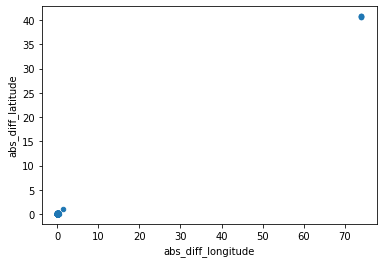

In [87]:
train_df.iloc[:2000].plot.scatter('abs_diff_longitude', 'abs_diff_latitude')

In [88]:
train_df = train_df[(train_df.abs_diff_longitude<5) & (train_df.abs_diff_latitude<5)]
print(len(train_df))

99804


In [89]:
import torch
import torch.nn as nn
from torch.autograd import Variable

In [90]:
model = nn.Sequential(nn.Linear(2, 10),
                     nn.Linear(10, 5),
                      nn.Linear(5, 1))
                   

In [91]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [92]:
X = np.stack((train_df.abs_diff_latitude.values,train_df.abs_diff_longitude.values)).T
X = torch.from_numpy(X)
X = X.type(torch.FloatTensor)

In [93]:
y = torch.from_numpy(train_df.fare_amount.values.T)
y = y.type(torch.FloatTensor)
y.unsqueeze_(-1)

tensor([[12.5000],
        [31.5000],
        [11.7000],
        ...,
        [ 4.9000],
        [12.1000],
        [10.9000]])

In [94]:
for epoch in range(90):
    # Forward Propagation
    y_pred = model(X)
    # Compute and print loss
    loss = criterion(y_pred, y)
    print('epoch: ', epoch,' loss: ', loss.item())
    # Zero the gradients
    optimizer.zero_grad()
    
    # perform a backward pass (backpropagation)
    loss.backward()
    
    # Update the parameters
    optimizer.step()

epoch:  0  loss:  219.89573669433594
epoch:  1  loss:  212.0519561767578
epoch:  2  loss:  204.7279510498047
epoch:  3  loss:  196.59242248535156
epoch:  4  loss:  186.5618438720703
epoch:  5  loss:  173.43675231933594
epoch:  6  loss:  156.04733276367188
epoch:  7  loss:  134.3359832763672
epoch:  8  loss:  112.1786117553711
epoch:  9  loss:  98.48381042480469
epoch:  10  loss:  95.57719421386719
epoch:  11  loss:  95.4637222290039
epoch:  12  loss:  95.4157485961914
epoch:  13  loss:  95.36750030517578
epoch:  14  loss:  95.31895446777344
epoch:  15  loss:  95.27009582519531
epoch:  16  loss:  95.22090148925781
epoch:  17  loss:  95.17132568359375
epoch:  18  loss:  95.12136840820312
epoch:  19  loss:  95.07100677490234
epoch:  20  loss:  95.02020263671875
epoch:  21  loss:  94.96892547607422
epoch:  22  loss:  94.91719055175781
epoch:  23  loss:  94.86490631103516
epoch:  24  loss:  94.8121109008789
epoch:  25  loss:  94.75872802734375
epoch:  26  loss:  94.70475769042969
epoch:  27

In [95]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)


In [96]:
for epoch in range(700):
    # Forward Propagation
    y_pred = model(X)
    # Compute and print loss
    loss = criterion(y_pred, y)
    print('epoch: ', epoch,' loss: ', loss.item())
    # Zero the gradients
    optimizer.zero_grad()
    
    # perform a backward pass (backpropagation)
    loss.backward()
    
    # Update the parameters
    optimizer.step()

epoch:  0  loss:  86.87495422363281
epoch:  1  loss:  86.84430694580078
epoch:  2  loss:  86.81353759765625
epoch:  3  loss:  86.78262329101562
epoch:  4  loss:  86.75157165527344
epoch:  5  loss:  86.72040557861328
epoch:  6  loss:  86.68907165527344
epoch:  7  loss:  86.65760803222656
epoch:  8  loss:  86.62600708007812
epoch:  9  loss:  86.5942611694336
epoch:  10  loss:  86.56238555908203
epoch:  11  loss:  86.53035736083984
epoch:  12  loss:  86.49817657470703
epoch:  13  loss:  86.46587371826172
epoch:  14  loss:  86.43341064453125
epoch:  15  loss:  86.40081787109375
epoch:  16  loss:  86.3680648803711
epoch:  17  loss:  86.33516693115234
epoch:  18  loss:  86.30213165283203
epoch:  19  loss:  86.26893615722656
epoch:  20  loss:  86.23560333251953
epoch:  21  loss:  86.20211791992188
epoch:  22  loss:  86.1684799194336
epoch:  23  loss:  86.13469696044922
epoch:  24  loss:  86.10074615478516
epoch:  25  loss:  86.066650390625
epoch:  26  loss:  86.03241729736328
epoch:  27  loss

In [100]:
add_travel_vector_features(test_df)


In [101]:
X_test = np.stack((test_df.abs_diff_latitude.values,test_df.abs_diff_longitude.values)).T
X_test = torch.from_numpy(X_test)
X_test = X_test.type(torch.FloatTensor)


In [102]:
y_test = model(X_test)


In [ ]:
y_test[:20]


In [105]:
y_test = y_test.detach().numpy()


In [106]:
y_test = y_test.reshape(-1)


In [107]:
y_test


array([ 9.358396 ,  9.86723  ,  7.6704893, ..., 39.03984  , 17.533674 ,
        8.91773  ], dtype=float32)

In [108]:
submission = pd.DataFrame(
    {'key': test_df.key, 'fare_amount': y_test},
    columns = ['key', 'fare_amount'])
submission.to_csv('submission.csv', index = False)
